In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import random
import os

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
tqdm.pandas()

In [77]:
import pandas as pd

def preprocess(sent, exclude, sp_tokens=False):
    sent = sent.lower()
    sent = re.sub("'", '', sent)
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.strip()
    sent = re.sub(" +", " ", sent)
    if sp_tokens:
        sent = '<start> ' + sent + ' <end>'
    return sent


class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word


def max_length(tensor):
    return max(len(t) for t in tensor)


def data_loader(path, batch_size, samples=None, max_len=None, reverse=False):
    data = pd.read_csv(path)
    data =  data.reset_index(drop=True)
    lines = list()
    for index, row in data.iterrows():
        column1_value = row['Romanized_Text']
        column2_value = row['Human_Annotated_Bengali_Text']
        col_list = [column1_value, column2_value]
        lines.append(col_list)

    if samples:
        random.shuffle(lines)
        lines = lines[:samples]

    if reverse:
        lines = [l[::-1] for l in lines]

    exclude = set(string.punctuation)
    prep_lines = [
        [preprocess(i, exclude, sp_tokens=False),
         preprocess(j, exclude, sp_tokens=True)]
        for i, j in lines
    ]
    inp_lang = LanguageIndex(en for en, ma in prep_lines)
    tgt_lang = LanguageIndex(ma for en, ma in prep_lines)
    input_tensor = [[inp_lang.word2idx[w] for w in inp.split(' ')]
                    for inp, tgt in prep_lines]

    target_tensor = [[tgt_lang.word2idx[w] for w in tgt.split(' ')]
                     for inp, tgt in prep_lines]
    if max_len:
        new_input_tensor = []
        new_target_tensor = []
        for i, j in zip(input_tensor, target_tensor):
            if (len(i) <= max_len) and (len(j) <= max_len):
                new_input_tensor.append(i)
                new_target_tensor.append(j)

        input_tensor = new_input_tensor
        target_tensor = new_target_tensor
        max_length_inp = max_length_tgt = max_len

    else:
        max_length_inp, max_length_tgt = max_length(input_tensor), max_length(target_tensor)

    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(
        input_tensor,
        maxlen=max_length_inp,
        padding='post')

    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(
        target_tensor,
        maxlen=max_length_tgt,
        padding='post')

    (input_tensor_train,
     input_tensor_val,
     target_tensor_train,
     target_tensor_val) = train_test_split(
         input_tensor,
         target_tensor,
         test_size=0.2,
         random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices(
        (input_tensor_train, target_tensor_train)
        ).shuffle(len(input_tensor_train)).batch(batch_size, drop_remainder=True)

    test_dataset = tf.data.Dataset.from_tensor_slices(
        (input_tensor_val, target_tensor_val)
        ).shuffle(len(input_tensor_val)).batch(batch_size, drop_remainder=True)
    return train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt

In [78]:
BATCH_SIZE = 256
EMBEDDING_DIM = 50
UNITS = 50
NUM_EPOCHS = 100
dataset_path = '/content/Dataset-5k.xlsx-Sheet1.csv'
train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt = data_loader(
    dataset_path, BATCH_SIZE)

vocab_inp_size = len(inp_lang.word2idx)
vocab_tgt_size = len(tgt_lang.word2idx)


In [80]:
def detokenize(tokens, idx2word):
    text = ""
    for t in tokens:
        if 'tensorflow' in str(type(tokens)):
            text += idx2word[t.numpy()] + ' '
        else:
            text += idx2word[t] + ' '
    text = text.replace(' <pad>', '')
    text = text.replace('<start>', '')
    text = text.replace('<end>', '')
    return text.strip()

banglish, bangla = next(iter(train_dataset))
print('Shape:', banglish.shape, bangla.shape)
print('Banlish Sentence:', detokenize(banglish[0], inp_lang.idx2word))
print('Bangla Sentence: ', detokenize(bangla[0], tgt_lang.idx2word))

In [82]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)

    def call(self, x):
        x = self.embedding(x)
        enc_outputs = self.rnn(x)
        return enc_outputs[0], enc_outputs[1:]
tmp_enc_outputs, tmp_enc_state = Encoder(
    EMBEDDING_DIM, UNITS, vocab_inp_size
)(banglish)

print(tmp_enc_outputs.shape, tmp_enc_state[-1].shape)

In [84]:
class hidden_layer(tf.keras.layers.Layer):

    def __init__(self, units):
        super().__init__()
        self.W_q = tf.keras.layers.Dense(units, use_bias=False)
        self.W_k = tf.keras.layers.Dense(units, use_bias=False)
        self.W_v = tf.keras.layers.Dense(1, use_bias=False)

    def call(self, query, key, value, mask=None):
        query, key = self.W_q(query), self.W_k(key)
        score = self.W_v(
            tf.math.tanh(
                tf.expand_dims(query, 2) + tf.expand_dims(key, 1)
            )
        )
        score = tf.squeeze(score, -1)
        if mask is not None:
            score = tf.where(mask, score, -1e6)
        attention_weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(attention_weights, value)
        return context, attention_weights

class Decoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)
        self.attention = hidden_layer(units)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, enc_outputs, state, mask=None):
        x = self.embedding(x)
        dec_outputs = self.rnn(x, initial_state=state)
        output = dec_outputs[0]
        state = dec_outputs[1:]
        context_vector, attention_weights = self.attention(
            query=output,
            key=enc_outputs,
            value=enc_outputs,
            mask=mask
        )
        context_rnn_output = tf.concat(
            [context_vector, output], axis=-1)
        pred = self.fc(context_rnn_output)
        return pred, state, attention_weights

tmp_dec_output, tmp_dec_state, tmp_att_wghts = Decoder(
    EMBEDDING_DIM, UNITS, vocab_tgt_size
)(bangla, tmp_enc_outputs, tmp_enc_state)

print(
    tmp_dec_output.shape,
    tmp_dec_state[-1].shape,
    tmp_att_wghts.shape
)

In [90]:
encoder = Encoder(EMBEDDING_DIM, UNITS, vocab_inp_size)
decoder = Decoder(EMBEDDING_DIM, UNITS, vocab_tgt_size)

def loss_fn(y_true, y_pred):
    mask = tf.cast(y_true != 0, tf.float32)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    loss = tf.reduce_sum(loss * mask)
    return loss
trainer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [94]:
history = {'train_loss': [], 'test_loss': []}
for epoch in range(NUM_EPOCHS):
    total_train_loss = 0.
    total_test_loss = 0.

    with tqdm(total=len(train_dataset)) as pbar:
        for batch, (x, y) in enumerate(train_dataset):
            inp_mask = tf.expand_dims(x != 0, axis=1)
            tgt_mask = tf.cast(y != 0, tf.float32)

            with tf.GradientTape() as tape:
                loss = tf.constant(0.0)
                enc_outputs, enc_states = encoder(x)
                dec_states = enc_states

                dec_input = tf.expand_dims(y[:, 0], axis=1)
                for t in range(1, x.shape[1]):
                    dec_outputs, dec_states, tmp_a = decoder(
                        dec_input, enc_outputs,
                        dec_states, inp_mask)

                    loss += loss_fn(
                        tf.expand_dims(y[:, t], axis=1), dec_outputs)
                    dec_input = tf.expand_dims(y[:, t], axis=1)

                loss = loss / tf.reduce_sum(tgt_mask)

            variables = (encoder.trainable_variables +
                         decoder.trainable_variables)
            gradients = tape.gradient(loss, variables)
            trainer.apply_gradients(zip(gradients, variables))
            total_train_loss += loss.numpy()
            pbar.update(1)

    epoch_train_loss = total_train_loss / len(train_dataset)
    history['train_loss'].append(epoch_train_loss)

    with tqdm(total=len(test_dataset)) as pbar:
        for batch, (x, y) in enumerate(test_dataset):
            inp_mask = tf.expand_dims(x != 0, axis=1)
            tgt_mask = tf.cast(y != 0, tf.float32)
            total_test_loss += loss.numpy()
            pbar.update(1)

    epoch_test_loss = total_test_loss / len(test_dataset)
    history['test_loss'].append(epoch_test_loss)

    print(f'Epoch: {epoch} | Train Loss: {epoch_train_loss} | Test Loss: {epoch_test_loss}')


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 6.996593134743827 | Test Loss: 6.114993572235107


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 5.766205378941128 | Test Loss: 5.7288899421691895


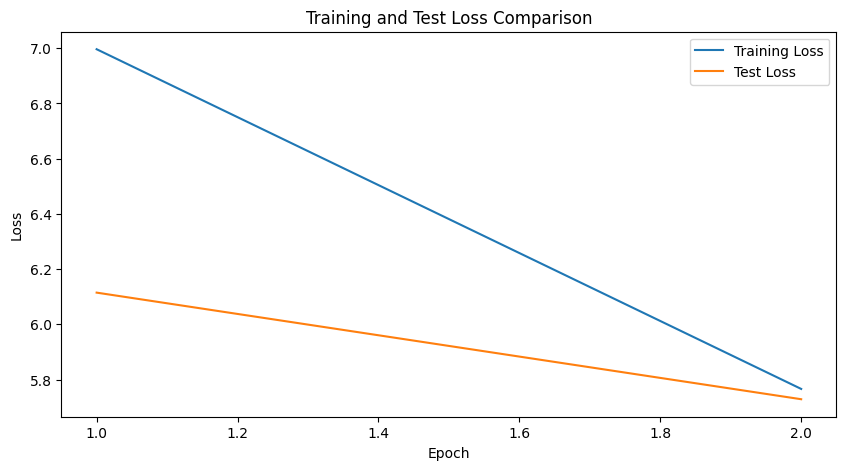



Final Training Loss: 5.766205378941128
Final Test Loss: 5.7288899421691895


In [97]:
epochs = list(range(1, NUM_EPOCHS + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
final_train_loss = history['train_loss'][-1]
final_test_loss = history['test_loss'][-1]

print("")
print("")
print(f'Final Training Loss: {final_train_loss}')
print(f'Final Test Loss: {final_test_loss}')

In [19]:
def predict_seq2seq(encoder, decoder, src_tokens, tgt_vocab, num_steps):
    enc_X = tf.expand_dims(src_tokens, axis=0)
    mask = tf.expand_dims(enc_X != 0, 1)

    enc_outputs, enc_state = encoder(enc_X, training=False)
    dec_state = enc_state

    dec_X = tf.expand_dims(tf.constant([tgt_vocab.word2idx['<start>']]), axis=0)
    output_seq = []
    attention_weights = []
    for _ in range(num_steps):
        Y, dec_state, att_wgts = decoder(
            dec_X, enc_outputs, dec_state, mask,training=False)
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        if pred[0].numpy() == tgt_vocab.word2idx['<end>']:
            break
        output_seq.append(pred[0].numpy())
        attention_weights.append(tf.squeeze(att_wgts, 0))

    attention_weights = tf.squeeze(tf.stack(attention_weights, axis=0), 1)
    return detokenize(output_seq, tgt_vocab.idx2word), attention_weights

banglish, bangla = next(iter(test_dataset))

for idx in range(20):
  actual_seq = detokenize(bangla[idx], tgt_lang.idx2word)
  translation, att_wgts = predict_seq2seq(encoder, decoder, banglish[idx], tgt_lang, max_length_tgt)

  eng_sent = detokenize(eng[idx], inp_lang.idx2word)
  print(f'Banglish Sentence:      {eng_sent}')
  print(f'Predicted Translation: {translation}')
  print(f'Actual Translation:    {actual_seq}')
  print("")
  print("-------------------------------------------------------------")